# 2021 Fall 信息检索 Project1

## 中文分词：最大匹配算法

加载必要的python库

In [1]:
import numpy as np
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
corpus_file = open("corpus.sentence.txt", "r", encoding="utf-8")

使用一个函数从文件中按行读取文本

In [3]:
def data_read(file):
    return file.readlines()

In [5]:
corpus = data_read(corpus_file)

读取词典文件

In [4]:
dict_file = open("corpus.dict.txt", "r", encoding="utf-8")

In [6]:
corpus_dict = data_read(dict_file)

In [7]:
corpus_dict[0].split()

['4537', '10']

此处意义是：词典长度为4537，单个词的最大长度是10

In [8]:
corpus_dict[1].split() #check data form

['沉静']

In [13]:
dict_len = 4537
max_word_len = 10

In [12]:
dict_array = []
for i in range(1,dict_len+1): #注意文件头部并非词典内容
    dict_array.append("".join(corpus_dict[i].split()))
    # 用join而非直接append是为了去方括号

In [57]:
def MaximumMatching(corpus):
  time_start=time.time()
  match_answer = []
  sentence_num = 0
  for line in corpus:
    per_sentence_answer = []
    pos = 0
    while pos<len(line): # 终止条件为pos到了当前这个句子的最大长度
        current_line_len = len(line)
        start_len = min(max_word_len, current_line_len-pos-1) # start_len指初始状态的最长匹配长度
        # 此处需要确定最大单词长，可能是10，也可能是当前匹配后剩下的部分
        for current_len in range(start_len,0,-1): # 从最大长度开始减，每次失败就-1
            if (line[pos:pos+current_len] in dict_array):
                per_sentence_answer.append(line[pos:pos+current_len]) # 往单句匹配结果加入当前匹配好的词
                pos=pos+current_len-1
             # position移动到匹配完单词后的下一个位置
                break;
            elif current_len == 1: # 只有单自可匹配则直接加入匹配结果中
                per_sentence_answer.append(line[pos:pos+current_len])
        pos+=1
    # 将当前句子的分词结果以列表形式append到答案中
    match_answer.append(per_sentence_answer)
    sentence_num+=1
  time_end=time.time()
  print("Total sentence number for word seg:",sentence_num)
  print('Total time cost',time_end-time_start,'s')
  return match_answer 

In [58]:
match_result = MaximumMatching(corpus)

Total sentence number for word seg: 803
Total time cost 10.873929500579834 s


Sanity Check

查看一下分词的大致状况

In [16]:
match_result[6]

['关于',
 '香港',
 '回归',
 '中国',
 '后',
 '的',
 '国际',
 '金融',
 '地位',
 '问题',
 '，',
 '戴相龙',
 '强调',
 '，',
 '香港',
 '的',
 '国际',
 '金融',
 '地位',
 '不但',
 '能够',
 '维持',
 '，',
 '而且',
 '还',
 '会',
 '得到',
 '加强',
 '。']

In [17]:
file = open("corpus.out.txt","w",encoding="utf8")
for res in match_result:
    for i in res:
        file.write(i+" ")
    file.write("\n")

In [18]:
answer_file = open("corpus.answer.txt", "r", encoding="utf-8")

In [19]:
correct_match = answer_file.readlines()

In [20]:
correct_match_len = len(correct_match)

以下部分为分词结果评估部分，首先实现一下F1-Score的计算

In [21]:
def cal_F1(precision,recall):
  return (2*precision*recall/(precision+recall))

In [31]:
len(correct_match)

803

构建函数完成分词结果与答案的匹配，细节请看comments

In [67]:
def check_performance(match_result,correct_match):
  OutputFile = open("performance.txt","w",encoding="utf8")
  OutputFile.write("Index\t Precision\t Recall\t F1-score\n")
  # 写Header
  compare_len = len(correct_match)
  check_index = 0
  for i in range(compare_len):
    check_index += 1 # 句子序号
    temp_len = len(match_result[i]) # 当前校验的句子的分词结果的长度
    valid_tokens = correct_match[i].split() # 正确的分词结果
    valid_len = len(valid_tokens) # 正确的分词结果的长度
    correct_sum = 0 # 维护一个变量记录多少个正确
    answer_pos = valid_pos = 0 # 位置指针
    seg_len = val_len = 0 # 两个变量来表示长度位置
    # 开始和答案配对
    current_corpus_len = len(corpus[i]) - 1 # -1是因为下标从0开始
    while(seg_len<current_corpus_len and val_len<current_corpus_len):
    # 被校验的分词结果和正确结果任意一个达到了最大长度则终止
    # 以下匹配答案，需要注意长度不一，分为三种情况讨论
        if seg_len == val_len:
          if (match_result[i][answer_pos] == valid_tokens[valid_pos]): correct_sum += 1 # 匹配正确则+1
          seg_len += len(match_result[i][answer_pos]) # 第i个句的当前位置
          val_len += len(valid_tokens[valid_pos])
          answer_pos += 1
          valid_pos += 1
        elif seg_len > val_len:
          val_len += len(valid_tokens[valid_pos]) # 当前tokens前移一位
          valid_pos += 1
        else: # 小
          seg_len += len(match_result[i][answer_pos]) # 当前的position前移一位
          answer_pos += 1
    # 计算三个指标 Precision Recall 和 F1-Score
    Precision = correct_sum/temp_len
    Recall = correct_sum/valid_len
    F1_score = cal_F1(Precision,Recall) #函数如上个cell的实现
    OutputFile.write("%d\t %.2f\t %.2f\t %.2f\n" % (check_index, Precision, Recall, F1_score))

In [68]:
check_performance(match_result,correct_match)

将计算好的三个指标存入文件，转为csv格式

In [69]:
df = pd.read_csv("performance.txt",delimiter="\t")
df.to_csv("performance.csv", encoding='utf-8', index=False)
df = pd.read_csv("performance.csv",header=0)

In [70]:
df.head(5)

,Index,Precision,Recall,F1-score
0,1,1.00,1.00,1.00
1,2,1.00,1.00,1.00
2,3,0.95,0.95,0.95
3,4,1.00,1.00,1.00
4,5,1.00,1.00,1.00


可视化对分词结果的评价

In [39]:
def metrics(data1,data2,data3):
    line1, = plt.plot(data1,'orange',label = 'Precision')
    line2, = plt.plot(data2,'green', label = 'Recall') 
    line3, = plt.plot(data3,'dodgerblue', label = 'F1-Score') 
    plt.gcf().set_size_inches(12, 6)
    plt.title('Per Sentence Metrics')
    plt.legend(handles=[line1, line2, line3], labels=['Precision','Recall','F1-Score'], loc='best')
    plt.grid(linestyle='-.')
    plt.ylim(0)
    plt.xlabel('sentence number')
    plt.ylabel('metric')
    plt.show()

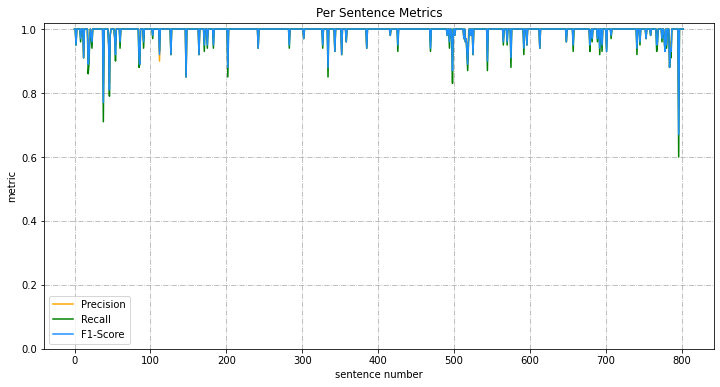

In [40]:
metrics(df[' Precision'],df[' Recall'],df[' F1-score'])

In [41]:
print("average Precision",np.mean(df[' Precision']))
print("average Recall",np.mean(df[' Recall']))
print("average F1-Score",np.mean(df[' F1-score']))

average Precision 0.9947198007471995
average Recall 0.9923412204234126
average F1-Score 0.99348692403487


In [42]:
print("worst Precision",np.min(df[' Precision']),"sentence",np.argmin(df[' Precision'])+1)
print("worst Recall",np.min(df[' Recall']),"sentence",np.argmin(df[' Recall'])+1)
print("worst F1-score",np.min(df[' F1-score']),"sentence",np.argmin(df[' F1-score'])+1)

worst Precision 0.75 sentence 797
worst Recall 0.6 sentence 797
worst F1-score 0.67 sentence 797


Case Study：
第797行文本为“【水蒸蛋糕】”，最大匹配分词结果为【 水蒸 蛋糕 】 ，答案为【 水 蒸 蛋糕 】 ，水蒸这个词在词典里，所以被匹配了，整个句子比较短，所以导致了准确率和召回率都出现了明显的下降